# Loading Dependencies

In [27]:
# Python Standard Libraries for importing data from binary file
import os
import os.path #for accessing the file path
import struct  #for unpacking the binary data

import time    #for calculating time

from urllib.request import urlopen #for downloading the dataset
from urllib.error import URLError, HTTPError

# import gzip as unzip #to unzip the downloaded dataset

#core packages
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Downloading Dataset

In [28]:
#help from  https://gist.github.com/kissgyorgy/6102803 for bufferring part
def download_dataset(dataset):
    
    if dataset == "mnist":
        urls = ["http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
                "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
                "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
                "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"] 
    
    elif dataset == "fashion_mnist":
        urls = ["http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz",
                "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz", 
                "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz",
                "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz" ] 
    else:
        raise ValueError("Only 'mnist' and 'fashion_mnist' dataset are supported")
    
    path = 'dataset/%s/'%(dataset)
    
    #creating a new destination path if it doesnot exist
    if not os.path.exists(path):
        print("No destination directory exists: Creating '" + path + "' as a new directory.\n")
        os.makedirs(path) #making directories recursively
    
    num_files = len(urls)

    print ("Downloading %s dataset..."%dataset)
    
    for ind, url in enumerate(urls):  
        filename = url.split('/')[-1] # getting the filename from the url
        print("\n%s:"%filename)
        
        #if file does not exist then download
        if not os.path.exists(path+filename):            
            try:                
                u = urlopen(url)
                with open(path + filename, 'wb') as data_file:
                    #getting the file size
                    file_size = int(u.info()["Content-Length"])
                    file_size_mb = file_size/(1024*1024) #for linux system use 1000 instead of 1024


                    downloaded_file_size = 0
                    block_size = 1024 #setting the block size to read the data from the url
                    while True:
                        #bufferring the file content
                        buffer = u.read(block_size)
                        if not buffer:
                            break
                        #adding up downloaded file size
                        downloaded_file_size += len(buffer)
                        downloaded_file_size_mb = downloaded_file_size/(1024*1024)

                        data_file.write(buffer)
                        #calculating the downloaded percentage of the file
                        down_percent = downloaded_file_size * 100. / file_size
                        inc = int(down_percent)//10
                        print ("%.3f MB  [%.3f MB done %s>%s %.0f%%]" %( file_size_mb, downloaded_file_size_mb, '=' * inc,'.'*(10-inc), down_percent), end = "\r")

            except HTTPError as e:
                print('Download Failed: ', e)
            except URLError as e:
                print('Download Failed: ', e)
        else:
            print("File already exists.")
    
    print("\n\nDataset downloaded.")

In [29]:
download_dataset(dataset = "mnist")


train-images-idx3-ubyte.gz:
File already exists.

train-labels-idx1-ubyte.gz:
File already exists.

t10k-images-idx3-ubyte.gz:
File already exists.

t10k-labels-idx1-ubyte.gz:
File already exists.


Dataset downloaded.


In [30]:
download_dataset(dataset = "fashion_mnist")

No destination directory exists: Creating 'dataset/fashion_mnist/' as a new directory.


train-images-idx3-ubyte.gz:
25.198 MB  [25.198 MB done ==========> 100%]
train-labels-idx1-ubyte.gz:
0.028 MB  [0.028 MB done ==========> 100%]
t10k-images-idx3-ubyte.gz:
4.217 MB  [4.217 MB done ==========> 100%]
t10k-labels-idx1-ubyte.gz:
0.005 MB  [0.005 MB done ==========> 100%]

Dataset downloaded.


## Unzip Dataset

In [ ]:
# # https://www.tutorialspoint.com/working-with-zip-files-in-python
# # https://www.geeksforgeeks.org/os-walk-python/


# def is_gzip(filename):
#     #checking the extention of the file to determine if it is a gzip file or not
#     ext = filename.split(".")[-1]
#     if ext == "gz":
#         return True

# def get_gzip_files(path):
#     files = []
#     #accessing all gzip files in the supplied path
#     for root, dirs, file in os.walk(path):
#         for fname in file:
#             if is_gzip(fname): #accessing only gzip file paths
#                 files.append(fname)
#     return files
      

    
# def decompress_dataset(dataset, keep_original = False):
#     path = 'dataset/%s/'%(dataset)
#     files = get_gzip_files(path)
    
#     if len(files) == 0:
#         print("No gzip file to decompress.")
#         return
    
#     for filename in files:
#         try:
#             with open(path + filename.split(".")[0],'wb') as fp: #opening a file on which the zip file content is to be written
#                 with unzip.open(path + filename, 'rb') as fzip: #opening the zip file to be unzipped
#                     file_data = fzip.read()
#                 fp.write(file_data) 
#             if keep_original == False:
#                 os.remove(path+filename) #removing the gzip file after decompression
#         except gzip.BadZipFile:
#             print('Error: Invalid gzip file encountered.')
#     print("Dataset decompressed...")



In [ ]:
# decompress_dataset(dataset = "fashion_mnist")

## Retriving data from binary file

In [2]:
def retrive_data(dataset="training-set"):
    """
        Retrive MNIST dataset from  the binary file into numpy arrays        
        
        Dataset Obtained From:
            - link -- http://yann.lecun.com/exdb/mnist/
            
        Dataset retrival code adapted from(but modified to our need making data retrival 6-8 times faster):
            - link -- https://www.cs.virginia.edu/~connelly/class/2015/large_scale/proj2/mnist_python
            
        Argument:
            - **dataset** -- type of dataset to be loaded. may be either 'training' or 'test'
        Returns:
            - **images** -- 3D array consisting of no. of examples, rows, columns of images 
            - **labels** -- array  containing labels for each images
    """
    path = "dataset/mnist"
    size = 60000
    
    #setting file path based on the dataset
    if dataset == "training-set":
        img_file_path = os.path.join(path, 'train-images-idx3-ubyte')
        lbl_file_path = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "test-set":
        img_file_path = os.path.join(path, 't10k-images-idx3-ubyte')
        lbl_file_path = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("Dataset must be 'training-set' or 'test-set'")
    
    #retriving the data
    with open(lbl_file_path, 'rb') as flbl:
        _, size = struct.unpack(">II", flbl.read(8))
        labels = np.frombuffer(flbl.read(), dtype=np.int8).reshape(size,1)

    with open(img_file_path, 'rb') as fimg:
        _, _, rows, cols = struct.unpack(">IIII", fimg.read(16))
        images = np.frombuffer(fimg.read(),dtype=np.uint8).reshape(size, rows, cols)
        
    assert(images.shape == (size, rows, cols))
    assert(labels.shape == (size,1))
    
    return images, labels



In [3]:
toc = time.time()

#retriving the data
train_x_orig, train_y_orig = retrive_data(dataset="training-set")
test_x_temp, test_y_temp = retrive_data(dataset="test-set")

tic = time.time()
#displaying the retrival info
print("Time to load data from binary file using numpy: " + str(1000*(tic-toc)) + "ms\n")
print("Data\t\t\t","Datatype\t\t","Shape")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_temp))+"\t",str(test_x_temp.shape))
print("Test Set Labels:\t" + str(type(test_y_temp))+"\t",str(test_y_temp.shape))
print("=================================================================")


Time to load data from binary file using numpy: 71.57373428344727ms

Data			 Datatype		 Shape
Training Set Images:	<class 'numpy.ndarray'>	 (60000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (60000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (10000, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (10000, 1)


## Dev-Test split

In [4]:
def dev_test_split(test_x,test_y):
    """
        Randomly splits the test set to dev and test set
        
        Arguments:
            test_x - test set images of size (10000,28,28)
            test_y - test set labels of size (10000,1)
        
        Returns:
            dev_x  - dev set images of size (5000,28,28)
            dev_y  - dev set labels of size (5000,1)
            test_x - test set images of size (5000,28,28)
            test_y - test set labels of size (5000,1)
    """
    m = test_y.shape[0]
    n = m // 2
    #suffling the test dataset
    randCol = np.random.permutation(m)
    suffled_x = test_x[randCol,:,:]
    suffled_y = test_y[randCol,:]
    
    #splitting the test set into dev and test set , 50% each
    dev_x = suffled_x[0:n,:,:]
    dev_y = suffled_y[0:n,:]
    
    test_x = suffled_x[n:m,:,:]
    test_y = suffled_y[n:m,:]
    
    assert(dev_x.shape == (n,28,28))
    assert(dev_y.shape == (n,1))
    assert(test_x.shape == (n,28,28))
    assert(test_y.shape == (n,1))
    
    return dev_x,dev_y,test_x,test_y

In [5]:
dev_x_orig,dev_y_orig,test_x_orig,test_y_orig = dev_test_split(test_x_temp, test_y_temp)

print("Data\t\t\t","Datatype\t\t","Shape")
print("=================================================================")
print("Dev Set Images:\t\t" + str(type(dev_x_orig))+"\t",str(dev_x_orig.shape))
print("Dev Set Labels:\t\t" + str(type(dev_y_orig))+"\t",str(dev_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")


Data			 Datatype		 Shape
Dev Set Images:		<class 'numpy.ndarray'>	 (5000, 28, 28)
Dev Set Labels:		<class 'numpy.ndarray'>	 (5000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (5000, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (5000, 1)


## Sample Dataset

In [6]:
#retriving a small sample of the original dataset for model development and experimentation
def sample_origDataset(x,y, sample_size):
    """
        Returns a sample dataset from the fully processed dataset
       
        Arguments:
            - **x** -- original input data
            - **y** -- original output labels
            - **sample_size** -- sample volume in percentage
        Returns:
            - **x_sample** -- input sample  from original dataset of size ( dataVol% of x)
            - **y_sample** -- output sample  from original dataset of size (datavol% of y)
    """
    m = y.shape[0]
    sample_m = int(np.multiply(m,np.divide(sample_size,100))) #int(m*(dataVol/100)) 
    
    #suffling the original dataset
    randCol = np.random.permutation(m)
    x_suffled = x[randCol,:,:]
    y_suffled = y[randCol,:]
    
    #taking samples of sample_size
    x_sample = x_suffled[0:sample_m,:,:]
    y_sample = y_suffled[0:sample_m,:]

    assert(x_sample.shape == (sample_m,28,28))
    assert(y_sample.shape == (sample_m,1))

    return x_sample, y_sample

In [7]:
sample_size = 50
train_x_sample, train_y_sample = sample_origDataset(train_x_orig, train_y_orig, sample_size)
dev_x_sample,dev_y_sample = sample_origDataset(dev_x_orig, dev_y_orig, sample_size )
test_x_sample,test_y_sample = sample_origDataset(test_x_orig, test_y_orig, sample_size)

print("Sample Size : %d%%\n"%(sample_size))
print("Data\t\t\t","Complete Dataset\t","Sample Dataset\t")
print("================================================================")
print("Training Set Images:\t"+ str(train_x_orig.shape)+"\t\t"+ str(train_x_sample.shape))
print("Training Set Labels:\t"+ str(train_y_orig.shape)+"\t\t"+ str(train_y_sample.shape))
print("Training Set Images:\t"+ str(dev_x_orig.shape)+"\t\t"+ str(dev_x_sample.shape))
print("Training Set Labels:\t"+ str(dev_y_orig.shape)+"\t\t"+ str(dev_y_sample.shape))
print("Test Set Images:\t"+str(test_x_orig.shape)+"\t\t"+ str(test_x_sample.shape))
print("Test Set Labels:\t"+str(test_y_orig.shape)+"\t\t"+ str(test_y_sample.shape))
print("================================================================")


Sample Size : 50%

Data			 Complete Dataset	 Sample Dataset	
Training Set Images:	(60000, 28, 28)		(30000, 28, 28)
Training Set Labels:	(60000, 1)		(30000, 1)
Training Set Images:	(5000, 28, 28)		(2500, 28, 28)
Training Set Labels:	(5000, 1)		(2500, 1)
Test Set Images:	(5000, 28, 28)		(2500, 28, 28)
Test Set Labels:	(5000, 1)		(2500, 1)


## Load dataset

In [8]:
def load_dataset():
    """
        Retrive the dataset from file into training, dev and test sets.
        
        Returns: 
        train_x_orig -  training set images consisting of no. of examples, rows, columns of images, 
                        size(60000,28,28)
        train_y_orig -  training set output consisting of image labels, size(60000,1)
        dev_x_orig  - dev set images of size (5000,28,28)
        dev_y_orig  - dev set labels of size (5000,1)
        test_x_orig - test set images of size (5000,28,28)
        test_y_orig - test set labels of size (5000,1)
        
    """
    #retriving data
    train_x_orig, train_y_orig = retrive_data(dataset="training-set")
    test_x_temp, test_y_temp = retrive_data(dataset="test-set")
    
    #Spliting the test set into dev and test set
    dev_x_orig,dev_y_orig,test_x_orig,test_y_orig = dev_test_split(test_x_temp, test_y_temp)
    
    return train_x_orig, train_y_orig, dev_x_orig,dev_y_orig,test_x_orig,test_y_orig

In [9]:
train_x_orig, train_y_orig, dev_x_orig,dev_y_orig,test_x_orig,test_y_orig = load_dataset()

print("Data\t\t\t","Datatype\t\t","Shape")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Dev Set Images:\t\t" + str(type(dev_x_orig))+"\t",str(dev_x_orig.shape))
print("Dev Set Labels:\t\t" + str(type(dev_y_orig))+"\t",str(dev_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")


Data			 Datatype		 Shape
Training Set Images:	<class 'numpy.ndarray'>	 (60000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (60000, 1)
Dev Set Images:		<class 'numpy.ndarray'>	 (5000, 28, 28)
Dev Set Labels:		<class 'numpy.ndarray'>	 (5000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (5000, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (5000, 1)


In [10]:
#loading sample dataset
def load_sample_dataset(sample_size = 100):
    """
        Retrive the sample dataset from file into training, dev and test sets.
        
        Argument:
            - **sample_size** -- sample volume in percentage

        Returns: 
        - **train_x_sample** -- input sample from training set of size ( sample_size% of train_x_orig)
        - **train_y_sample** -- output sample from training set of size (sample_size% of train_y_orig)
        - **dev_x_sample** -- input sample from dev set of size ( sample_size% of dev_x_orig)
        - **dev_y_sample** -- output sample from dev set of size (sample_size% of dev_y_orig)
        - **test_x_sample** -- input sample from test set of size ( sample_size% of test_x_orig)
        - **test_y_sample** -- output sample from test set of size (sample_size% of test_y_orig)        
    """
    #loading the original dataset
    train_x_orig, train_y_orig, dev_x_orig,dev_y_orig,test_x_orig,test_y_orig = load_dataset()

    
    #sampling from the dataset
    train_x_sample, train_y_sample = sample_origDataset(train_x_orig, train_y_orig, sample_size)
    dev_x_sample,dev_y_sample = sample_origDataset(dev_x_orig, dev_y_orig, sample_size)
    test_x_sample,test_y_sample = sample_origDataset(test_x_orig, test_y_orig, sample_size)
    

    return train_x_sample, train_y_sample, dev_x_sample, dev_y_sample, test_x_sample, test_y_sample

In [11]:
sample_size = 50
train_x_sample, train_y_sample, dev_x_sample, dev_y_sample, test_x_sample, test_y_sample = load_sample_dataset(sample_size)

print("Sample Size : %d%%\n"%(sample_size))
print("Data\t\t\t","Complete Dataset\t","Sample Dataset\t")
print("================================================================")
print("Training Set Images:\t"+ str(train_x_orig.shape)+"\t\t"+ str(train_x_sample.shape))
print("Training Set Labels:\t"+ str(train_y_orig.shape)+"\t\t"+ str(train_y_sample.shape))
print("Training Set Images:\t"+ str(dev_x_orig.shape)+"\t\t"+ str(dev_x_sample.shape))
print("Training Set Labels:\t"+ str(dev_y_orig.shape)+"\t\t"+ str(dev_y_sample.shape))
print("Test Set Images:\t"+str(test_x_orig.shape)+"\t\t"+ str(test_x_sample.shape))
print("Test Set Labels:\t"+str(test_y_orig.shape)+"\t\t"+ str(test_y_sample.shape))
print("================================================================")


Sample Size : 50%

Data			 Complete Dataset	 Sample Dataset	
Training Set Images:	(60000, 28, 28)		(30000, 28, 28)
Training Set Labels:	(60000, 1)		(30000, 1)
Training Set Images:	(5000, 28, 28)		(2500, 28, 28)
Training Set Labels:	(5000, 1)		(2500, 1)
Test Set Images:	(5000, 28, 28)		(2500, 28, 28)
Test Set Labels:	(5000, 1)		(2500, 1)


## Visualizing and Validating Raw datasets

In [12]:
#dataset visualization using charts
def visual_charts(train_y_orig, dev_y_orig, test_y_orig):
    """
        Plots bar graph showing the number of examples in each class

        Arguments:
            trainy_orig - labels of training set
            dev_y_orig - labels of dev set
            test_y_orig - labels of test set
    """
    datasets = {"Training Set":train_y_orig,"Dev Set": dev_y_orig,"Test Set": test_y_orig}
    
    #setting the plot style
    plt.style.use('seaborn')
    
    #creating subplots
    fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(10,15))
    fig.subplots_adjust(hspace=.2)
    i = 0
    
    #plotting the bar graph for each dataset labels
    for dataset,datalabel in datasets.items():
        unique, counts = np.unique(datalabel, return_counts=True)    
        axes[i].bar(unique, counts)
        max_value = np.max(counts)
        axes[i].set(xticks = unique, ylim = (0,max_value + max_value // 10))
        axes[i].set_title("Number of Examples in " + dataset , fontsize = 16)
        axes[i].set_xlabel("Classes", fontsize = 12)
        axes[i].set_ylabel("Number of Examples", fontsize = 12)
        i += 1

    plt.show()

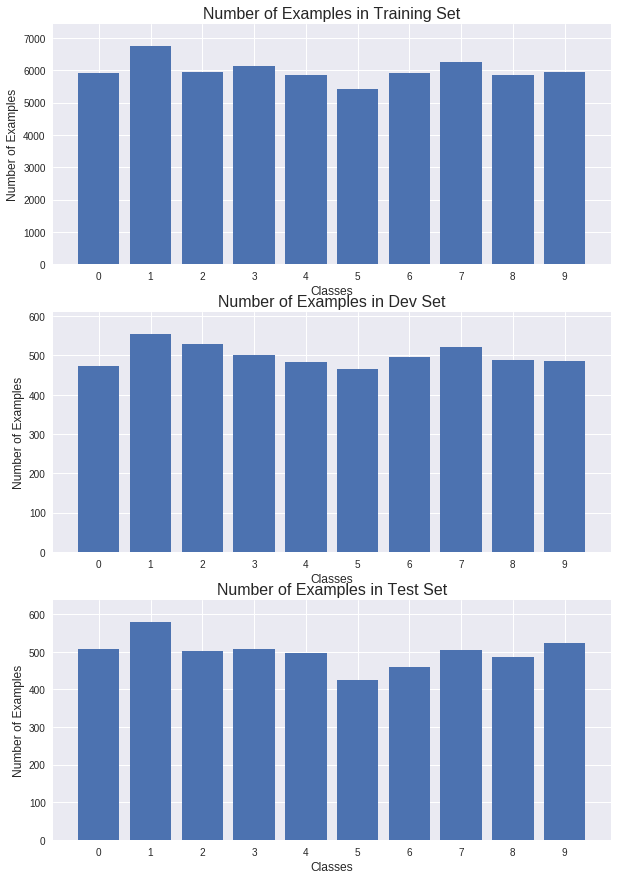

In [13]:
visual_charts(train_y_orig, dev_y_orig, test_y_orig)

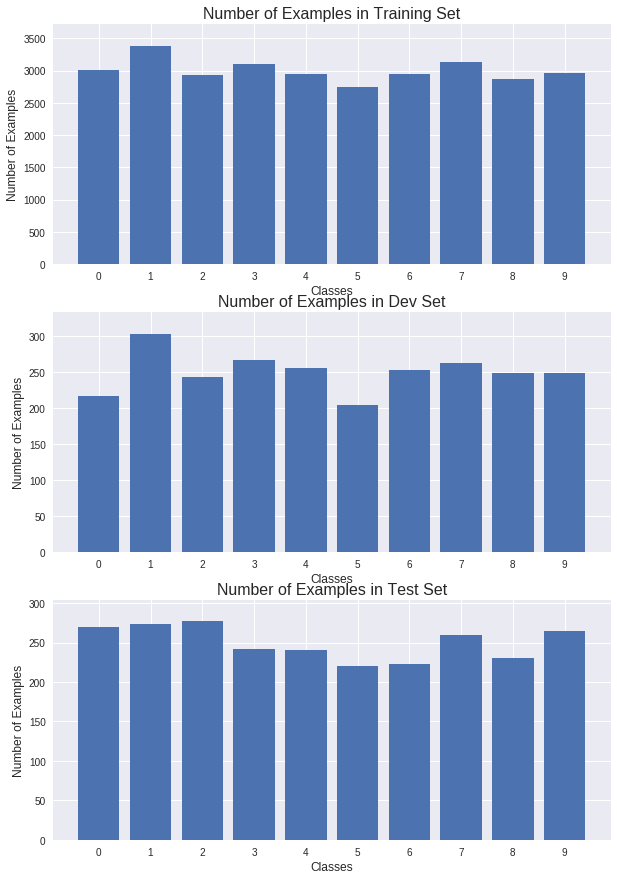

In [14]:
visual_charts(train_y_sample, dev_y_sample, test_y_sample)

In [15]:
def visualize_dataset(x_orig, y_orig, dataset = "training"):
    """
        Plots 10 sample images from the dataset with labels
        
        Arguments:
            x_orig - 3D array representation of input images
            y_orig - array of labels
            dataset - type of dataset, can be training, dev or test
        
    """
    #recovering matplotlib defaults
    plt.rcParams.update(plt.rcParamsDefault) 
    
    #checking dataset type
    if(dataset == "training"):
        visual_title = "Training Data Set"
        rng = range(1040,1050)
    elif(dataset == "dev"):
        visual_title = "Dev Data Set"
        rng = range(100,110)
    elif(dataset == "test"):
        visual_title = "Test Data Set"
        rng = range(540,550)        
    else:
        raise ValueError("Dataset set must be training or dev or test set")
     
    #creating subplots
    fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(16,8))
    fig.subplots_adjust(hspace=.1)
    fig.suptitle(visual_title)
    
    #plotting the sample images along with their labels
    for ax,i in zip(axes.flatten(),rng):
        ax.imshow(x_orig[i].squeeze(),interpolation='nearest')
        ax.set(title = "Label: "+ str(y_orig[i,0]))

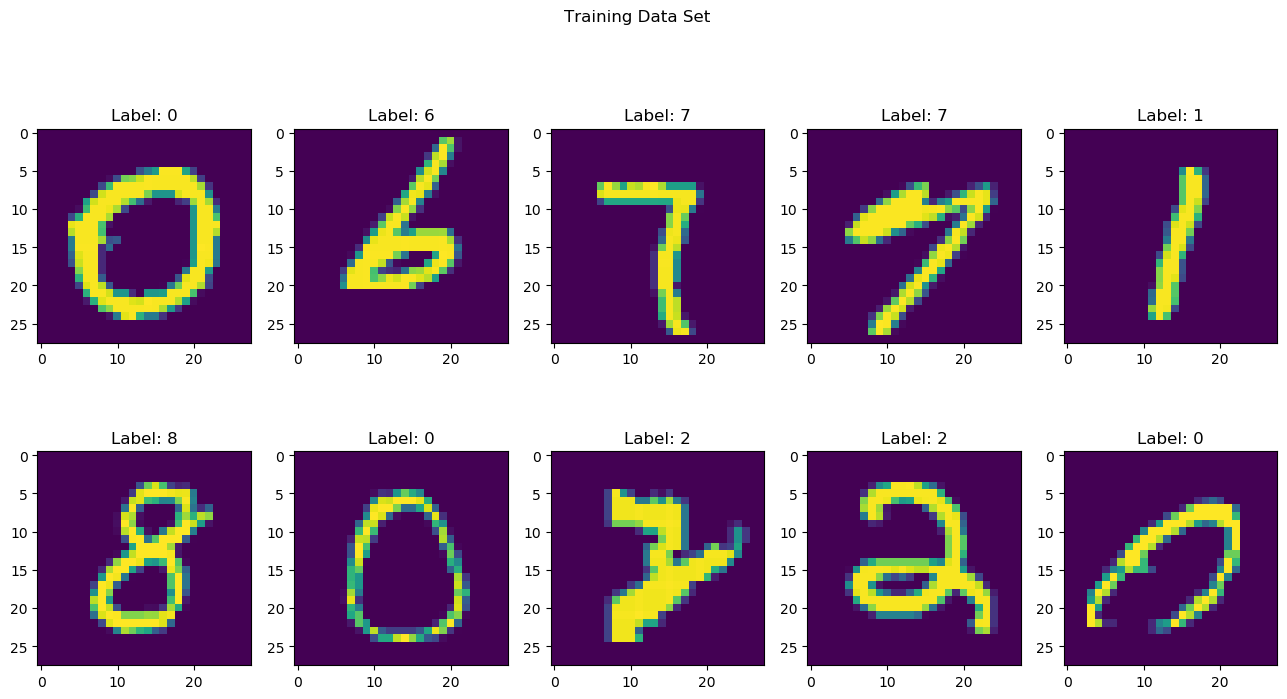

In [16]:
visualize_dataset(train_x_orig, train_y_orig, dataset = "training")

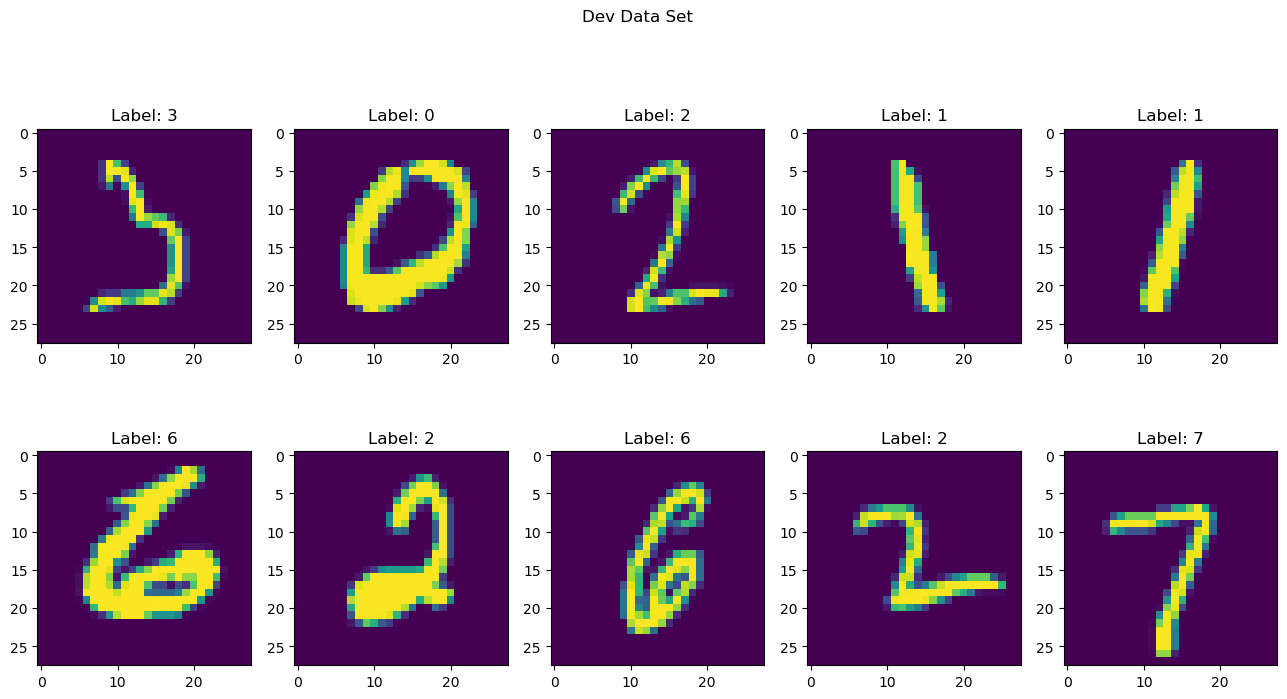

In [17]:
visualize_dataset(dev_x_orig, dev_y_orig, dataset = "dev")

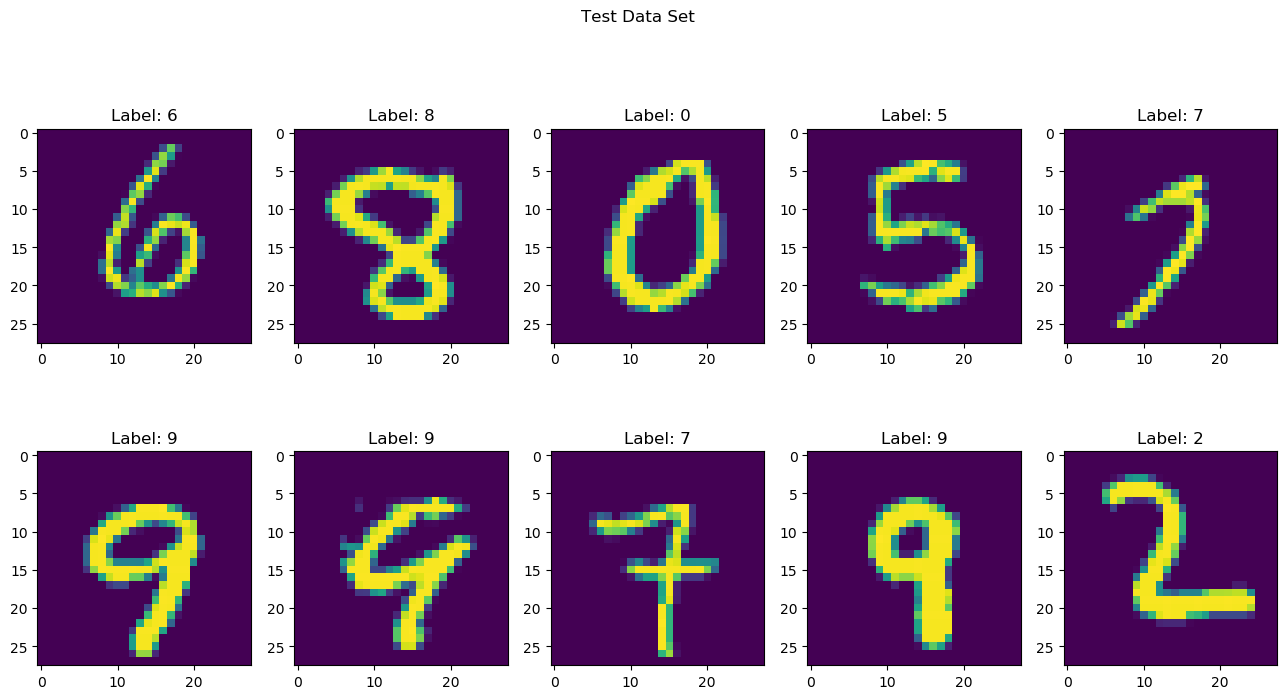

In [18]:
visualize_dataset(test_x_orig, test_y_orig, dataset="test")

# Preparing Dataset

## Flattening the images

In [19]:
def flatten_input(train_x_orig,dev_x_orig,test_x_orig):
    """
        Flattens the 3D numpy array of the input images
        
        Arguement:
            train_x_orig -  training set images of size (60000,28,28)
            dev_x_orig   - dev set images of size (5000,28,28)
            test_x_orig  - test set images of size (5000,28,28)

        Returns:
            train_x_flatten - flattened training set input data of size (784,60000)
            dev_flatten     - flattened training set dev data of size (784,5000)
            test_x_flatten  - flattened test set input data of size (784,5000)
            
    """
    m = train_x_orig.shape[0] #number of examples in training set
    n = dev_x_orig.shape[0] # number of examples in dev and test set
    
    
    #flattening the image--The "-1" makes reshape flatten the remaining dimensions
    train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   
    dev_x_flatten = dev_x_orig.reshape(dev_x_orig.shape[0], -1).T    
    test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
   
    
    assert(train_x_flatten.shape == (784,m) )
    assert(dev_x_flatten.shape == (784,n) )
    assert(test_x_flatten.shape == (784,n) )
    
    return train_x_flatten, dev_x_flatten, test_x_flatten

In [20]:
train_x_flatten,dev_x_flatten,test_x_flatten = flatten_input(train_x_orig,dev_x_orig,test_x_orig)

print("Data\t\t\t","Shape")
print("=====================================")
print ("Input Training set:\t" + str(train_x_flatten.shape))
print ("Input Dev set:\t\t" + str(dev_x_flatten.shape))
print ("Input Test set:\t\t" + str(test_x_flatten.shape))
print("=====================================")

Data			 Shape
Input Training set:	(784, 60000)
Input Dev set:		(784, 5000)
Input Test set:		(784, 5000)


## Normalizing the images

In [21]:
def normalize_input(train_x_flatten,dev_x_flatten,test_x_flatten ):
    """
        Normalizes the pixel values of the flattened images to the range 0-1
        
        Arguement:
            train_x_flatten - flattened training set input data of size (784,60000)
            dev_flatten     - flattened training set dev data of size (784,5000)
            test_x_flatten  - flattened test set input data of size (784,5000)
        Returns:
            train_x_norm - normalized training set input data
            dev_norm     - normalized training set dev data
            test_x_norm  - normalized test set input data
    """
    m = train_x_flatten.shape[1]
    n = dev_x_flatten.shape[1]
    
    # Normalizing the data into the range between 0 and 1.
    train_x_norm = np.divide(train_x_flatten,255.)
    dev_x_norm = np.divide(dev_x_flatten,255.)
    test_x_norm = np.divide(test_x_flatten,255.)
    
    assert(train_x_norm.shape == (784,m) )
    assert(dev_x_norm.shape == (784,n) )
    assert(test_x_norm.shape == (784,n) )
    
    return train_x_norm, dev_x_norm, test_x_norm

In [22]:
train_x_norm, dev_x_norm, test_x_norm = normalize_input(train_x_flatten,dev_x_flatten,test_x_flatten)

print("Data\t\t\t","Shape")
print("=====================================")
print ("Input Training set:\t" + str(train_x_norm.shape))
print ("Input Dev set:\t\t" + str(dev_x_norm.shape))
print ("Input Test set:\t\t" + str(test_x_norm.shape))
print("=====================================")

Data			 Shape
Input Training set:	(784, 60000)
Input Dev set:		(784, 5000)
Input Test set:		(784, 5000)


## Encoding the labels

In [23]:
def one_hot_encoding(y_orig,num_classes = 10):
    """
        Transform the output labels into the one-hot encoding representation
        
        Arguments:
            y_orig - raw labels loaded directly from the binary file
            num_classes - number of the classes based on which the transformation is to be made
        Returns:
            y_encoded - encoded ndarray of the labels with data elements of int type
    """
    #encoding the labels
    y_encoded = np.eye(num_classes)[y_orig.reshape(-1)].T


    assert(y_encoded.shape == (num_classes, y_orig.shape[1]))
    return y_encoded

In [24]:
toc = time.time()
#encoding the output of the training and the test dataset
train_y_encoded = one_hot_encoding(train_y_orig.T)
dev_y_encoded = one_hot_encoding(dev_y_orig.T)
test_y_encoded = one_hot_encoding(test_y_orig.T)
tic = time.time()
print("Time to encode: " + str(1000*(tic-toc)) + " ms\n")

print("Data\t\t\t","Shape")
print("===================================")
print ("Output Training set:\t" + str(train_y_encoded.shape))
print ("Output Dev set:\t\t" + str(dev_y_encoded.shape))
print ("Output Test set:\t" + str(test_y_encoded.shape))
print("===================================")

Time to encode: 1.3623237609863281 ms

Data			 Shape
Output Training set:	(10, 60000)
Output Dev set:		(10, 5000)
Output Test set:	(10, 5000)


## Prep Dataset

In [25]:
def prep_dataset(train_x_orig, train_y_orig, dev_x_orig, dev_y_orig, test_x_orig, test_y_orig):
    """
        Flatten and Normalize the input images and encode the output labels
        
        Arguments:
            train_x_orig -  training set images of size (60000,28,28)
            train_y_orig -  training set labels of size (60000,1)
            dev_x_orig   - dev set images of size (5000,28,28)
            dev_y_orig   - dev set labels of size (5000,1)
            test_x_orig  - test set images of size (5000,28,28)
            test_y_orig  - test set labels of size (5000,1)
        Returns:
            train_x_norm - flattened and normalized training set input data
            dev_norm     - flattened and normalized training set dev data
            test_x_norm  - flattened and normalized test set input data
            train_y_encoded - encoded label of training set
            dev_y_encoded   - encoded label of dev set
            test_y_encoded  - encoded label of test set
    """
    #flatten the input images
    train_x_flatten,dev_x_flatten,test_x_flatten = flatten_input(train_x_orig,dev_x_orig,test_x_orig)
    
    #normalize the input images
    train_x_norm, dev_x_norm, test_x_norm = normalize_input(train_x_flatten,dev_x_flatten,test_x_flatten)
    
    #encode the output labels
    train_y_encoded = one_hot_encoding(train_y_orig.T)
    dev_y_encoded = one_hot_encoding(dev_y_orig.T)
    test_y_encoded = one_hot_encoding(test_y_orig.T)
    
    return train_x_norm,train_y_encoded, dev_x_norm,dev_y_encoded, test_x_norm, test_y_encoded

In [26]:
train_x_norm,train_y_encoded, dev_x_norm,dev_y_encoded, test_x_norm, test_y_encoded = prep_dataset(train_x_orig, train_y_orig, dev_x_orig, dev_y_orig, test_x_orig, test_y_orig)
print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_x_orig.shape)+"\t\t"+ str(train_x_norm.shape))
print("Training Set Labels:\t" + str(train_y_orig.shape)+"\t\t"+ str(train_y_encoded.shape))
print("Dev Set Images:\t\t" + str(dev_x_orig.shape)+"\t\t"+ str(dev_x_norm.shape))
print("Dev Set Labels:\t\t" + str(dev_y_orig.shape)+"\t\t"+ str(dev_y_encoded.shape))
print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_norm.shape))
print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_encoded.shape))
print("=================================================================")

Data			 Before Processing	 After Processing
Training Set Images:	(60000, 28, 28)		(784, 60000)
Training Set Labels:	(60000, 1)		(10, 60000)
Dev Set Images:		(5000, 28, 28)		(784, 5000)
Dev Set Labels:		(5000, 1)		(10, 5000)
Test Set Images:	(5000, 28, 28)		(784, 5000)
Test Set Labels:	(5000, 1)		(10, 5000)
